# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [48]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

notebook_dir = os.getcwd()  

if notebook_dir.endswith('examples'):
    project_root = os.path.dirname(notebook_dir)
else:
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        project_root = os.path.dirname(notebook_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [49]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [50]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [51]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=100,  # Simulation time horizon
    lam=0.01,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=.9,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100          # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [52]:
# Create DPR scheduler with reduction
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=10,           # Full game has 10 players (N)
    reduction_size=4,         # Reduced game has 4 players (n)
    subgame_size=min(4, len(strategies)),
    batch_size=5,
    seed=42
)

# Print information about the scaling
print(f"DPR Scaling Info: {scheduler.get_scaling_info()}")
# Expected output: DPR Scaling Info: {'full_game_players'
# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=1000,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

DPR Scaling Info: {'full_game_players': 10, 'reduced_game_players': 4, 'scaling_factor': 3.0, 'is_reduced': True}


In [53]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100, 
    profiles_per_iteration=100,  
    save_frequency=1,   
    verbose=True         
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  3%|▎         | 3/100 [00:00<00:04, 24.11it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 188.50028242145197
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -942.5014121072599
MELO Trade: Agent 18, Side -1, Quantity 5, Price 188.50028242145197
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 942.5014121072599
MELO Trade: Agent 17, Side 1, Quantity 5, Price 283.88287398421846
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1419.4143699210922
MELO Trade: Agent 16, Side -1, Quantity 5, Price 283.88287398421846
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1419.4143699210922


 15%|█▌        | 15/100 [00:00<00:03, 23.70it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -289.6836878250934
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1448.4184391254669
MELO Trade: Agent 18, Side -1, Quantity 5, Price -289.6836878250934
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1448.4184391254669
MELO Trade: Agent 18, Side 1, Quantity 5, Price -465.02724852219654
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2325.1362426109827
MELO Trade: Agent 17, Side -1, Quantity 5, Price -465.02724852219654
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2325.1362426109827
MELO Trade: Agent 17, Side 1, Quantity 5, Price -284.15978978775547
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1420.7989489387774
MELO Trade: Agent 16, Side -1, Quantity 5, Price -284.15978978775547
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1420.7989489387774


 45%|████▌     | 45/100 [00:01<00:02, 20.35it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -424.1344152097088
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2120.672076048544
MELO Trade: Agent 16, Side -1, Quantity 5, Price -424.1344152097088
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2120.672076048544


 57%|█████▋    | 57/100 [00:02<00:01, 23.45it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 208.34311719439876
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1041.7155859719937
MELO Trade: Agent 16, Side -1, Quantity 5, Price 208.34311719439876
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1041.7155859719937
MELO Trade: Agent 18, Side 1, Quantity 5, Price -501.0611710634255
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2505.3058553171277
MELO Trade: Agent 16, Side -1, Quantity 5, Price -501.0611710634255
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2505.3058553171277


 66%|██████▌   | 66/100 [00:02<00:01, 23.44it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -410.3864360500794
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2051.932180250397
MELO Trade: Agent 16, Side -1, Quantity 5, Price -410.3864360500794
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2051.932180250397


 75%|███████▌  | 75/100 [00:03<00:00, 25.07it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 209.5737881686967
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1047.8689408434834
MELO Trade: Agent 16, Side -1, Quantity 5, Price 209.5737881686967
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1047.8689408434834
MELO Trade: Agent 17, Side 1, Quantity 5, Price -90.74472545382258
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 453.7236272691129
MELO Trade: Agent 18, Side -1, Quantity 5, Price -90.74472545382258
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -453.7236272691129


 81%|████████  | 81/100 [00:03<00:00, 21.32it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 263.6515454578825
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1318.2577272894125
MELO Trade: Agent 17, Side -1, Quantity 5, Price 263.6515454578825
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1318.2577272894125


 87%|████████▋ | 87/100 [00:03<00:00, 23.78it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-888.8602])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 4444.300842285156
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-888.8602])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -4444.300842285156
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([371.5305])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1857.6524353027344
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([371.5305])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1857.6524353027344


100%|██████████| 100/100 [00:04<00:00, 23.49it/s]


Simulating profile 2/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 100/100 [00:02<00:00, 43.81it/s]


Simulating profile 3/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


Simulating profile 4/5: ['MELO_0_100', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Simulating profile 5/5: ['MELO_0_100', 'MELO_0_100', 'MELO_100_0', 'MELO_100_0']


  9%|▉         | 9/100 [00:00<00:04, 20.15it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1823.5405])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -9117.70263671875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1823.5405])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 9117.70263671875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-797.5583])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3987.7914428710938
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-797.5583])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3987.7914428710938
MELO Trade: Agent 18, Side 1, Quantity 5, Price 107.36355954893858
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -536.8177977446929
MELO Trade: Agent 17, Side -1, Quantity 5, Price 107.36355954893858
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 536.8177977446929


 20%|██        | 20/100 [00:00<00:03, 20.22it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 270.98860134596896
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1354.943006729845
MELO Trade: Agent 17, Side -1, Quantity 5, Price 270.98860134596896
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1354.943006729845
MELO Trade: Agent 17, Side 1, Quantity 5, Price 26.889054221612387
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -134.44527110806195
MELO Trade: Agent 18, Side -1, Quantity 5, Price 26.889054221612387
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 134.44527110806195
MELO Trade: Agent 18, Side 1, Quantity 5, Price 251.51349699880132
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1257.5674849940065
MELO Trade: Agent 17, Side -1, Quantity 5, Price 251.51349699880132
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1257.5674849940065


 26%|██▌       | 26/100 [00:01<00:03, 18.53it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([13.1199])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -65.5994987487793
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([13.1199])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 65.5994987487793


 28%|██▊       | 28/100 [00:01<00:04, 17.13it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -121.9673475518971
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 609.8367377594856
MELO Trade: Agent 17, Side -1, Quantity 5, Price -121.9673475518971
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -609.8367377594856
MELO Trade: Agent 18, Side 1, Quantity 5, Price 823.286322955259
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -4116.431614776295
MELO Trade: Agent 17, Side -1, Quantity 5, Price 823.286322955259
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 4116.431614776295


 44%|████▍     | 44/100 [00:02<00:02, 19.66it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 254.4148629100399
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1272.0743145501995
MELO Trade: Agent 17, Side -1, Quantity 5, Price 254.4148629100399
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1272.0743145501995


 50%|█████     | 50/100 [00:02<00:02, 18.80it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 222.08227914762654
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1110.4113957381328
MELO Trade: Agent 17, Side -1, Quantity 5, Price 222.08227914762654
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1110.4113957381328


 59%|█████▉    | 59/100 [00:03<00:02, 20.32it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 358.6654054166647
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1793.3270270833236
MELO Trade: Agent 18, Side -1, Quantity 5, Price 358.6654054166647
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1793.3270270833236


 65%|██████▌   | 65/100 [00:03<00:01, 20.38it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([361.1003])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1805.5012512207031
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([361.1003])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1805.5012512207031
MELO Trade: Agent 17, Side 1, Quantity 5, Price -171.32205575109023
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 856.6102787554512
MELO Trade: Agent 18, Side -1, Quantity 5, Price -171.32205575109023
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -856.6102787554512


 71%|███████   | 71/100 [00:03<00:01, 20.20it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1083.8666])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 5419.3328857421875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1083.8666])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -5419.3328857421875


 80%|████████  | 80/100 [00:04<00:01, 19.99it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([510.7941])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2553.9706420898438
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([510.7941])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2553.9706420898438


100%|██████████| 100/100 [00:05<00:00, 19.65it/s]

Simulation completed in 24.58 seconds

Payoff data from simulation:
  Profile: [MELO_0_100:3, MELO_100_0:1], Avg Payoff: 42810.4824, Payoffs: [164985.314921875, 2408.4406945800783, 1789.8037561035155, 2058.370401611328]
  Profile: [MELO_0_100:4], Avg Payoff: 1341.4398, Payoffs: [1480.3473986816407, 901.6705859375, 1516.7372607421876, 1467.0039068603517]
  Profile: [MELO_100_0:4], Avg Payoff: 172846.6165, Payoffs: [166102.21671875, 178648.4440625, 176454.566484375, 170181.23859375]
  Profile: [MELO_0_100:1, MELO_100_0:3], Avg Payoff: 127795.0878, Payoffs: [175387.683515625, 168776.007734375, 167016.66, 0.0]
  Profile: [MELO_0_100:2, MELO_100_0:2], Avg Payoff: 85111.8707, Payoffs: [165733.863203125, 169406.851640625, 2600.3627185058594, 2706.405076904297]

Finding equilibria...
QUIESCE iteration 1/3 with 13 candidates
    Candidate regret: 0.633367
    Candidate regret: 0.000000
    Found equilibrium with regret 0.000000: MELO_100_0:1.0000
    Candidate regret: 0.052648
    Candidate reg

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [54]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


Top strategies by frequency:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


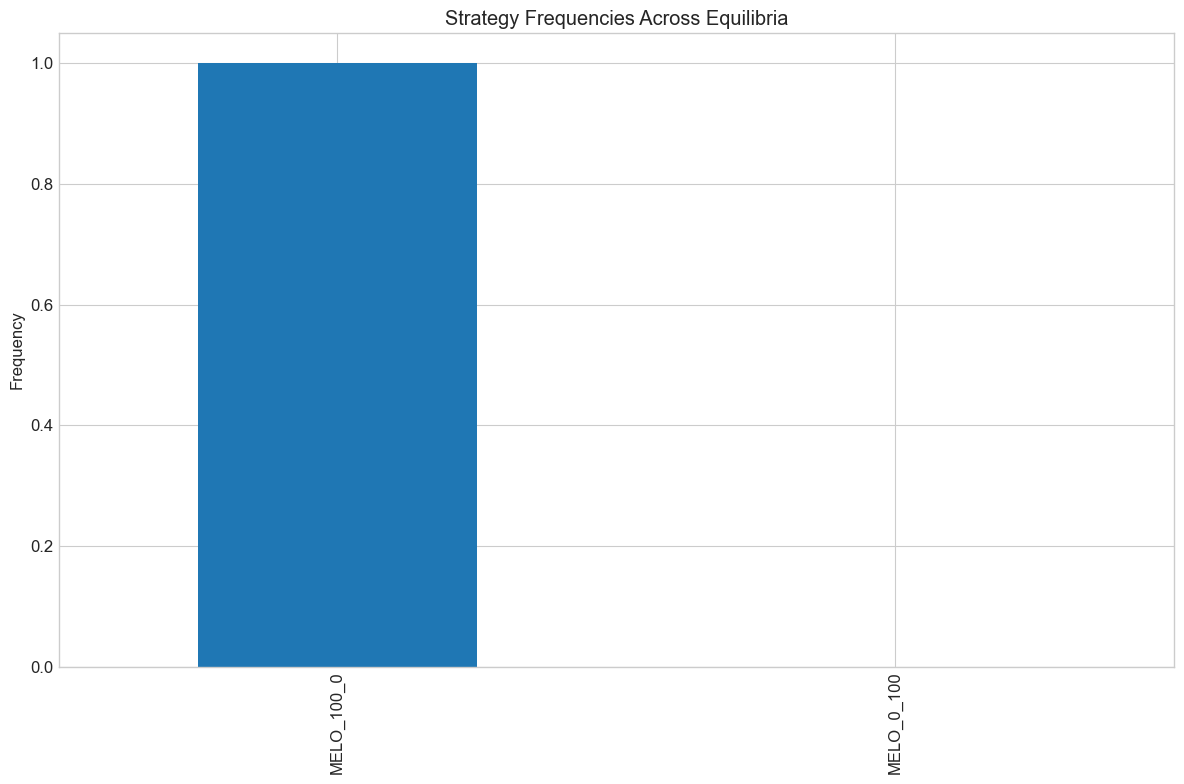

In [55]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [56]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [57]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [58]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [59]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [60]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [61]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_strategic=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    scheduler = DPRScheduler(
        strategies=strategies,
        num_players=10,           # Full game has 10 players (N)
        reduction_size=4,         # Reduced game has 4 players (n)
        subgame_size=min(3, len(strategies)),
        batch_size=5,
        seed=42
    )

    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [62]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([584.4805])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2922.40234375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([584.4805])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2922.40234375
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-634.8217])
Agent 17 MELO Profit before trade: 2922.40234375
Agent 17 MELO Profit after trade: 6096.510925292969
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-634.8217])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -3174.1085815429688
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-368.1117])
Agent 17 MELO Profit before trade: 6096.510925292969
Agent 17 MELO Profit after trade: 7937.069396972656
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-368.1117])
Agent 16 MELO Profit before trade: -2922.40234375
Agent 16 MELO Profit after trade: -4762.9608154296875
MELO Trade: Agent 1

100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price 612.8877821304877
Agent 18 MELO Profit before trade: -966.0466713138794
Agent 18 MELO Profit after trade: -4030.485581966318
MELO Trade: Agent 17, Side -1, Quantity 5, Price 612.8877821304877
Agent 17 MELO Profit before trade: 9710.165934009192
Agent 17 MELO Profit after trade: 12774.60484466163
MELO Trade: Agent 17, Side 1, Quantity 5, Price -1291.84214638874
Agent 17 MELO Profit before trade: 12774.60484466163
Agent 17 MELO Profit after trade: 19233.81557660533
MELO Trade: Agent 18, Side -1, Quantity 5, Price -1291.84214638874
Agent 18 MELO Profit before trade: -4030.485581966318
Agent 18 MELO Profit after trade: -10489.696313910019
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-106.1661])
Agent 17 MELO Profit before trade: 19233.81557660533
Agent 17 MELO Profit after trade: 19764.645959906113
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-106.1661])
Agent 18 MELO Profit before trade: -10489.696313910019
Agent 18 ME

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 459.5140551689292
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2297.570275844646
MELO Trade: Agent 16, Side -1, Quantity 5, Price 459.5140551689292
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2297.570275844646
MELO Trade: Agent 17, Side 1, Quantity 5, Price -604.6341547623192
Agent 17 MELO Profit before trade: -2297.570275844646
Agent 17 MELO Profit after trade: 725.6004979669501
MELO Trade: Agent 15, Side -1, Quantity 5, Price -604.6341547623192
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -3023.170773811596
MELO Trade: Agent 15, Side 1, Quantity 5, Price -97.18670284659379
Agent 15 MELO Profit before trade: -3023.170773811596
Agent 15 MELO Profit after trade: -2537.2372595786273
MELO Trade: Agent 17, Side -1, Quantity 5, Price -97.18670284659379
Agent 17 MELO Profit before trade: 725.6004979669501
Agent 17 MELO Profit after trade: 239.66698373398117
MELO Tra

 50%|█████     | 1/2 [00:00<00:00,  8.17it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 158.02107900770156
Agent 16 MELO Profit before trade: 1262.1503907317585
Agent 16 MELO Profit after trade: 472.0449956932507
MELO Trade: Agent 15, Side -1, Quantity 5, Price 158.02107900770156
Agent 15 MELO Profit before trade: -2036.8735295680829
Agent 15 MELO Profit after trade: -1246.768134529575
MELO Trade: Agent 17, Side 1, Quantity 5, Price 257.5911953230216
Agent 17 MELO Profit before trade: 774.723138836324
Agent 17 MELO Profit after trade: -513.2328377787841
MELO Trade: Agent 18, Side -1, Quantity 5, Price 257.5911953230216
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1287.955976615108
MELO Trade: Agent 18, Side 1, Quantity 5, Price 84.18093277354879
Agent 18 MELO Profit before trade: 1287.955976615108
Agent 18 MELO Profit after trade: 867.0513127473641
MELO Trade: Agent 15, Side -1, Quantity 5, Price 84.18093277354879
Agent 15 MELO Profit before trade: -1246.768134529575
Agent 15 MELO Profit after trade

100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 234.06138438577096
Agent 16 MELO Profit before trade: -4997.648777913245
Agent 16 MELO Profit after trade: -6167.955699842099
MELO Trade: Agent 18, Side -1, Quantity 5, Price 234.06138438577096
Agent 18 MELO Profit before trade: 11994.370835639882
Agent 18 MELO Profit after trade: 13164.677757568737
MELO Trade: Agent 17, Side 1, Quantity 5, Price 156.0795472654312
Agent 17 MELO Profit before trade: -7002.563143979358
Agent 17 MELO Profit after trade: -7782.960880306514
MELO Trade: Agent 15, Side -1, Quantity 5, Price 156.0795472654312
Agent 15 MELO Profit before trade: 5.841086252721425
Agent 15 MELO Profit after trade: 786.2388225798774
MELO Trade: Agent 17, Side 1, Quantity 5, Price 246.12722352491357
Agent 17 MELO Profit before trade: -7782.960880306514
Agent 17 MELO Profit after trade: -9013.596997931081
MELO Trade: Agent 15, Side -1, Quantity 5, Price 246.12722352491357
Agent 15 MELO Profit before trade: 786.2388225798774
Agent 15 ME

100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


 50%|█████     | 1/2 [00:00<00:00,  5.07it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -0.27884838869105977
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1.3942419434552988
MELO Trade: Agent 17, Side -1, Quantity 5, Price -0.27884838869105977
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1.3942419434552988
MELO Trade: Agent 18, Side 1, Quantity 5, Price 29.615874618079815
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -148.0793730903991
MELO Trade: Agent 16, Side -1, Quantity 5, Price 29.615874618079815
Agent 16 MELO Profit before trade: 1.3942419434552988
Agent 16 MELO Profit after trade: 149.4736150338544
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([37.5502])
Agent 16 MELO Profit before trade: 149.4736150338544
Agent 16 MELO Profit after trade: -38.277392046223724
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([37.5502])
Agent 18 MELO Profit before trade: -148.0793730903991
Agent 18 MELO Profit after trade: 39.67163398967904
MEL

100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-215.4416])
Agent 17 MELO Profit before trade: -2120.941547933708
Agent 17 MELO Profit after trade: -1043.733524862419
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-215.4416])
Agent 16 MELO Profit before trade: 2120.941547933708
Agent 16 MELO Profit after trade: 1043.733524862419
MELO Trade: Agent 18, Side 1, Quantity 5, Price -597.8784311174777
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2989.3921555873885
MELO Trade: Agent 17, Side -1, Quantity 5, Price -597.8784311174777
Agent 17 MELO Profit before trade: -1043.733524862419
Agent 17 MELO Profit after trade: -4033.1256804498075
MELO Trade: Agent 18, Side 1, Quantity 5, Price 192.0934550415651
Agent 18 MELO Profit before trade: 2989.3921555873885
Agent 18 MELO Profit after trade: 2028.924880379563
MELO Trade: Agent 17, Side -1, Quantity 5, Price 192.0934550415651
Agent 17 MELO Profit before trade: -4033.1256804498075
Agent 17 MELO Profit aft

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 263.45064453005375
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -1317.2532226502688
MELO Trade: Agent 18, Side -1, Quantity 5, Price 263.45064453005375
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1317.2532226502688
MELO Trade: Agent 16, Side 1, Quantity 5, Price -216.29723653542823
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1081.4861826771412
MELO Trade: Agent 15, Side -1, Quantity 5, Price -216.29723653542823
Agent 15 MELO Profit before trade: -1317.2532226502688
Agent 15 MELO Profit after trade: -2398.73940532741
MELO Trade: Agent 17, Side 1, Quantity 5, Price 359.3380690727317
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1796.6903453636585
MELO Trade: Agent 18, Side -1, Quantity 5, Price 359.3380690727317
Agent 18 MELO Profit before trade: 1317.2532226502688
Agent 18 MELO Profit after trade: 3113.9435680139272
MELO Trade: Agent 1

 50%|█████     | 1/2 [00:00<00:00,  7.67it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 212.96849684485707
Agent 15 MELO Profit before trade: -3765.4749530983045
Agent 15 MELO Profit after trade: -4830.31743732259
MELO Trade: Agent 16, Side -1, Quantity 5, Price 212.96849684485707
Agent 16 MELO Profit before trade: 2438.0474322984273
Agent 16 MELO Profit after trade: 3502.8899165227126
MELO Trade: Agent 17, Side 1, Quantity 5, Price 201.21021324255244
Agent 17 MELO Profit before trade: -3153.251594984945
Agent 17 MELO Profit after trade: -4159.3026611977075
MELO Trade: Agent 16, Side -1, Quantity 5, Price 201.21021324255244
Agent 16 MELO Profit before trade: 3502.8899165227126
Agent 16 MELO Profit after trade: 4508.940982735475
MELO Trade: Agent 16, Side 1, Quantity 5, Price 201.21021324255244
Agent 16 MELO Profit before trade: 4508.940982735475
Agent 16 MELO Profit after trade: 3502.8899165227126
MELO Trade: Agent 17, Side -1, Quantity 5, Price 201.21021324255244
Agent 17 MELO Profit before trade: -4159.3026611977075
Agent 

100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


MELO Trade: Agent 17, Side 1, Quantity 5, Price 100.6361501528466
Agent 17 MELO Profit before trade: -367.2631710304943
Agent 17 MELO Profit after trade: -870.4439217947272
MELO Trade: Agent 16, Side -1, Quantity 5, Price 100.6361501528466
Agent 16 MELO Profit before trade: -2896.8300774798076
Agent 16 MELO Profit after trade: -2393.6493267155747
MELO Trade: Agent 17, Side 1, Quantity 5, Price 103.84873687266645
Agent 17 MELO Profit before trade: -870.4439217947272
Agent 17 MELO Profit after trade: -1389.6876061580595
MELO Trade: Agent 18, Side -1, Quantity 5, Price 103.84873687266645
Agent 18 MELO Profit before trade: 0.5286645765660296
Agent 18 MELO Profit after trade: 519.7723489398983
MELO Trade: Agent 17, Side 1, Quantity 5, Price 108.76194132436387
Agent 17 MELO Profit before trade: -1389.6876061580595
Agent 17 MELO Profit after trade: -1933.497312779879
MELO Trade: Agent 16, Side -1, Quantity 5, Price 108.76194132436387
Agent 16 MELO Profit before trade: -2393.6493267155747
Agen

100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 365.5460064216537
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1827.7300321082685
MELO Trade: Agent 17, Side -1, Quantity 5, Price 365.5460064216537
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1827.7300321082685
MELO Trade: Agent 16, Side 1, Quantity 5, Price -415.0208576242312
Agent 16 MELO Profit before trade: -1827.7300321082685
Agent 16 MELO Profit after trade: 247.3742560128876
MELO Trade: Agent 17, Side -1, Quantity 5, Price -415.0208576242312
Agent 17 MELO Profit before trade: 1827.7300321082685
Agent 17 MELO Profit after trade: -247.3742560128876
MELO Trade: Agent 17, Side 1, Quantity 5, Price 179.8335696835634
Agent 17 MELO Profit before trade: -247.3742560128876
Agent 17 MELO Profit after trade: -1146.5421044307045
MELO Trade: Agent 18, Side -1, Quantity 5, Price 179.8335696835634
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 899.167848417817
MELO Tra

 50%|█████     | 1/2 [00:00<00:00,  3.22it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 271.5800476054575
Agent 16 MELO Profit before trade: 9260.506979651143
Agent 16 MELO Profit after trade: 7902.606741623857
MELO Trade: Agent 17, Side -1, Quantity 5, Price 271.5800476054575
Agent 17 MELO Profit before trade: -19584.50103442365
Agent 17 MELO Profit after trade: -18226.600796396364
MELO Trade: Agent 16, Side 1, Quantity 5, Price 367.80724677052257
Agent 16 MELO Profit before trade: 7902.606741623857
Agent 16 MELO Profit after trade: 6063.570507771244
MELO Trade: Agent 18, Side -1, Quantity 5, Price 367.80724677052257
Agent 18 MELO Profit before trade: 10323.99405477251
Agent 18 MELO Profit after trade: 12163.030288625123
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([550.6302])
Agent 17 MELO Profit before trade: -18226.600796396364
Agent 17 MELO Profit after trade: -20979.75173633777
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([550.6302])
Agent 18 MELO Profit before trade: 12163.030288625123
Agent 18 ME

100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price 1570.039045378141
Agent 18 MELO Profit before trade: 6999.252354710687
Agent 18 MELO Profit after trade: -850.9428721800186
MELO Trade: Agent 17, Side -1, Quantity 5, Price 1570.039045378141
Agent 17 MELO Profit before trade: -6645.499343924485
Agent 17 MELO Profit after trade: 1204.6958829662199
MELO Trade: Agent 16, Side 1, Quantity 5, Price 385.33070551795277
Agent 16 MELO Profit before trade: -353.75301078620055
Agent 16 MELO Profit after trade: -2280.4065383759644
MELO Trade: Agent 17, Side -1, Quantity 5, Price 385.33070551795277
Agent 17 MELO Profit before trade: 1204.6958829662199
Agent 17 MELO Profit after trade: 3131.349410555984
MELO Trade: Agent 17, Side 1, Quantity 5, Price 821.8522618958613
Agent 17 MELO Profit before trade: 3131.349410555984
Agent 17 MELO Profit after trade: -977.911898923322
MELO Trade: Agent 16, Side -1, Quantity 5, Price 821.8522618958613
Agent 16 MELO Profit before trade: -2280.4065383759644
Agent 16 ME

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price -95.39437453872264
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 476.97187269361325
MELO Trade: Agent 16, Side -1, Quantity 5, Price -95.39437453872264
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -476.97187269361325
MELO Trade: Agent 16, Side 1, Quantity 5, Price -52.441047082862454
Agent 16 MELO Profit before trade: -476.97187269361325
Agent 16 MELO Profit after trade: -214.766637279301
MELO Trade: Agent 17, Side -1, Quantity 5, Price -52.441047082862454
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -262.20523541431226
MELO Trade: Agent 18, Side 1, Quantity 5, Price -69.34110986475639
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 346.70554932378195
MELO Trade: Agent 15, Side -1, Quantity 5, Price -69.34110986475639
Agent 15 MELO Profit before trade: 476.97187269361325
Agent 15 MELO Profit after trade: 130.2663233698313
MELO Trade: Agent 

 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 5.987108428204699
Agent 15 MELO Profit before trade: -2821.7989991169406
Agent 15 MELO Profit after trade: -2851.7345412579643
MELO Trade: Agent 16, Side -1, Quantity 5, Price 5.987108428204699
Agent 16 MELO Profit before trade: 2697.77291557573
Agent 16 MELO Profit after trade: 2727.708457716754
MELO Trade: Agent 15, Side 1, Quantity 5, Price -107.20276666147564
Agent 15 MELO Profit before trade: -2851.7345412579643
Agent 15 MELO Profit after trade: -2315.720707950586
MELO Trade: Agent 18, Side -1, Quantity 5, Price -107.20276666147564
Agent 18 MELO Profit before trade: 404.941541912933
Agent 18 MELO Profit after trade: -131.07229139444513
MELO Trade: Agent 17, Side 1, Quantity 5, Price -112.25468885204685
Agent 17 MELO Profit before trade: -280.91545837172316
Agent 17 MELO Profit after trade: 280.35798588851117
MELO Trade: Agent 15, Side -1, Quantity 5, Price -112.25468885204685
Agent 15 MELO Profit before trade: -2315.720707950586
Agen

100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


MELO Trade: Agent 17, Side 1, Quantity 5, Price -195.52266817811474
Agent 17 MELO Profit before trade: -1699.3315128206586
Agent 17 MELO Profit after trade: -721.718171930085
MELO Trade: Agent 18, Side -1, Quantity 5, Price -195.52266817811474
Agent 18 MELO Profit before trade: -1116.7986016901168
Agent 18 MELO Profit after trade: -2094.4119425806903
MELO Trade: Agent 16, Side 1, Quantity 5, Price -147.10657892468572
Agent 16 MELO Profit before trade: -127.83214896958577
Agent 16 MELO Profit after trade: 607.7007456538428
MELO Trade: Agent 17, Side -1, Quantity 5, Price -147.10657892468572
Agent 17 MELO Profit before trade: -721.718171930085
Agent 17 MELO Profit after trade: -1457.2510665535135
MELO Trade: Agent 15, Side 1, Quantity 5, Price 51.251324716353935
Agent 15 MELO Profit before trade: 2943.9622634803627
Agent 15 MELO Profit after trade: 2687.7056398985933
MELO Trade: Agent 18, Side -1, Quantity 5, Price 51.251324716353935
Agent 18 MELO Profit before trade: -2094.4119425806903

100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 5

Running experiment with holding_period=5, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


 50%|█████     | 1/2 [00:00<00:00,  9.06it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 85.40627341359689
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -427.03136706798443
MELO Trade: Agent 15, Side -1, Quantity 5, Price 85.40627341359689
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 427.03136706798443


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


 50%|█████     | 1/2 [00:00<00:00,  8.53it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 91.54790976715691
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -457.73954883578455
MELO Trade: Agent 15, Side -1, Quantity 5, Price 91.54790976715691
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 457.73954883578455


100%|██████████| 2/2 [00:00<00:00,  8.01it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([729.5227])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -3647.613525390625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([729.5227])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3647.613525390625
Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 164.2271255727378
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -821.135627863689
MELO Trade: Agent 18, Side -1, Quantity 5, Price 164.2271255727378
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 821.135627863689
MELO Trade: Agent 18, Side 1, Quantity 5, Price 154.57124757786733
Agent 18 MELO Profit before trade: 821.135627863689
Agent 18 MELO Profit after trade: 48.2793899743524
MELO Trade: Agent 15, Side -1, Quantity 5, Price 154.57124757786733
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 772.8562378893366
Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 10

Running experiment with holding_period=10, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

Completed experiment. Found 1 equilibria.


Top strategy by holding period and arrival rate:


lam,0.05,0.10,0.20
holding_period,,,
1,MELO_100_0,MELO_100_0,MELO_100_0
5,MELO_100_0,MELO_100_0,MELO_100_0
10,MELO_100_0,MELO_100_0,MELO_100_0


<Figure size 1200x800 with 0 Axes>

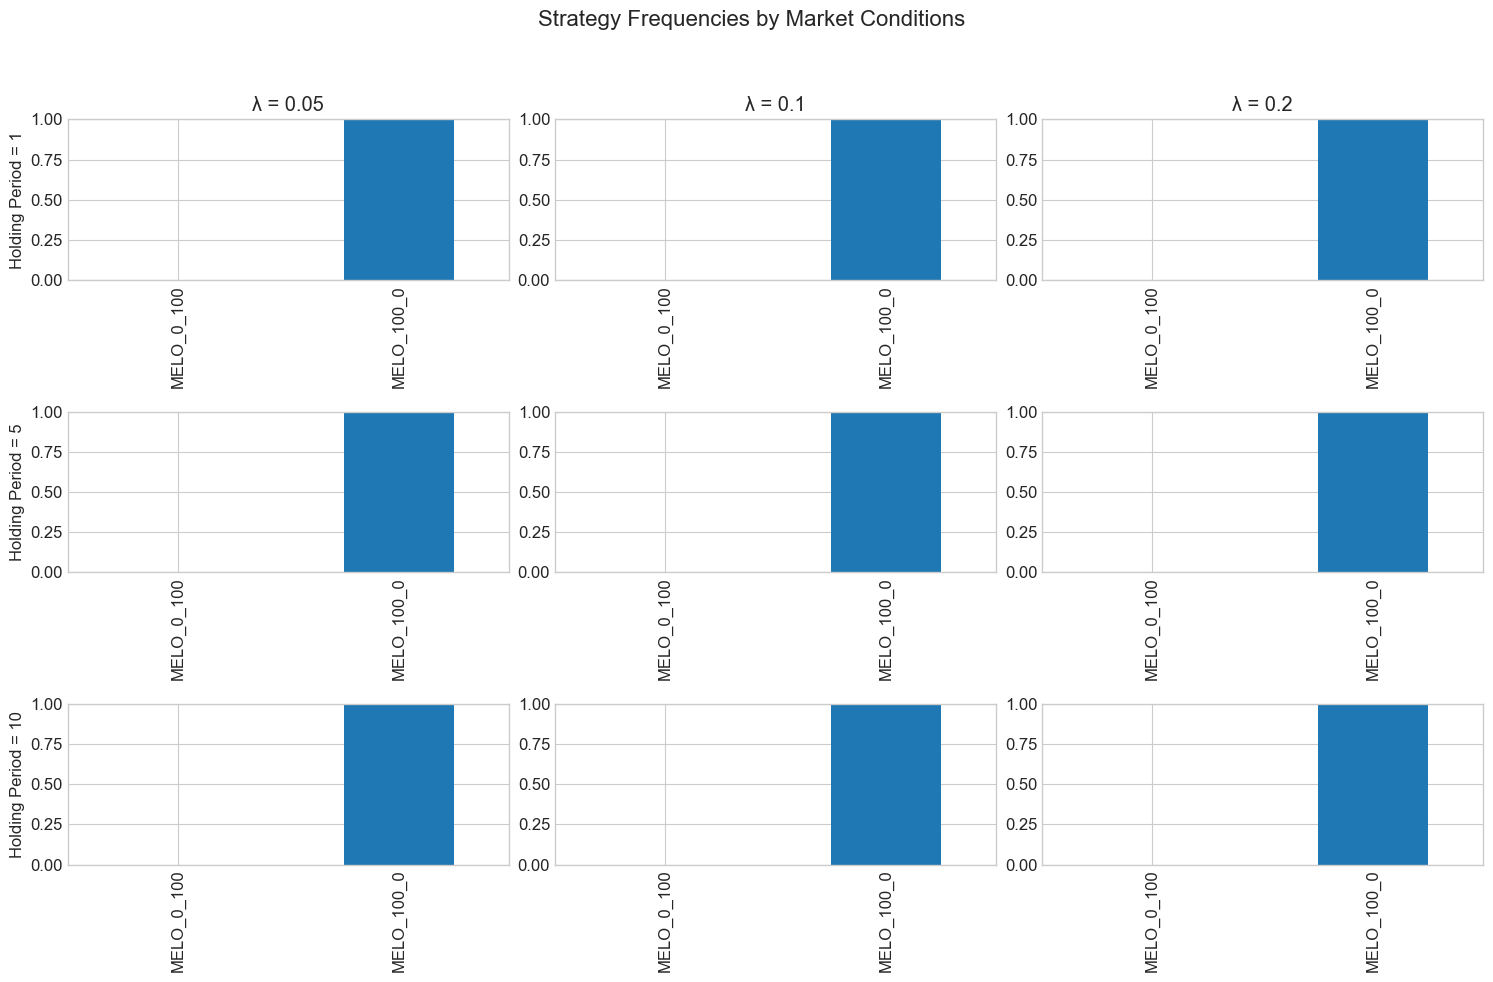

In [63]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [64]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [65]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])